# Breakfast Restaurant Locations
The aim of this notebook is to determine which communities in Calgary are best suited for a newly opening breakfast restaurant.

## Acquisition and Processing

In [96]:
# Import libs
import pandas as pd
import numpy as np
import plotly.offline as py # TODO switch to online mode to generate iframe-ready graphs on plot.ly
import plotly.graph_objs as go
import folium
import json, requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's start by gathering the 2016 census data, which is already grouped into communities. We need to use data from 2016, as this was the most recent year that demographic information was collected. The next census with demographics will be later this year (2019). Additionally, since all Open Calgary data is available via the SODA API, we can select columns in our request (a bit like SQL). 

In [4]:
request_fields = ['CLASS', 'CLASS_CODE', 'COMM_CODE', 'NAME', 'COMM_STRUCTURE', 'RES_CNT', 'DWELL_CNT', 'EMPLYD_CNT',
                  'MF_0_4', 'MF_5_14', 'MF_15_19', 'MF_20_24', 'MF_25_34', 'MF_35_44', 'MF_45_54', 'MF_55_64', 'MF_65_74', 'MF_75']
url = 'https://data.calgary.ca/resource/mndt-3a4i.csv?$select=' + ','.join(request_fields) # Census 2016
print(url)
census = pd.read_csv(url)
census.head()

https://data.calgary.ca/resource/mndt-3a4i.csv?$select=CLASS,CLASS_CODE,COMM_CODE,NAME,COMM_STRUCTURE,RES_CNT,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_5_14,MF_15_19,MF_20_24,MF_25_34,MF_35_44,MF_45_54,MF_55_64,MF_65_74,MF_75


,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,MF_35_44,MF_45_54,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,0,0,0,0,0,0,MANCHESTER INDUSTRIAL,0
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,4,4,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15
2,Major Park,3,COP,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,CANADA OLYMPIC PARK,0
3,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,115,30,20,0,12,0,FOOTHILLS,304
4,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,31,47,65,9,37,23,SHEPARD INDUSTRIAL,273


We also want geodata on every community. `calgary_geo` is a geojson file defining the boundries of all communities ([downloaded from here](https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6)). `comm_locs` is the centroids of all communities, from [this dataset](https://data.calgary.ca/Base-Maps/Community-Points/j9ps-fyst).

In [7]:
calgary_geo = 'data/Community Boundaries.geojson' # This should be identical to the multipolygon field included in the census, but it saves me some hassle of transforming data for Folium's picky needs.
request_fields = ['COMM_CODE', 'latitude', 'longitude']
url = 'https://data.calgary.ca/resource/kzbm-mn66.csv?$select=' + ','.join(request_fields) # 
comm_locs = pd.read_csv(url)
comm_locs.head()

,COMM_CODE,latitude,longitude
0,EYA,51.012993,-114.073623
1,ESH,50.951252,-113.950957
2,PEN,51.045863,-113.947522
3,SCE,51.112684,-114.217279
4,RAN,51.119163,-114.183601


In [14]:
census = census.merge(comm_locs, on='COMM_CODE')
census.head()

,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,MF_35_44,MF_45_54,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT,latitude,longitude
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,0,0,0,0,0,0,MANCHESTER INDUSTRIAL,0,51.013263,-114.057269
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,4,4,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15,50.984817,-114.037243
2,Major Park,3,COP,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,CANADA OLYMPIC PARK,0,51.080787,-114.217426
3,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,115,30,20,0,12,0,FOOTHILLS,304,50.994166,-113.981982
4,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,31,47,65,9,37,23,SHEPARD INDUSTRIAL,273,50.961480,-113.992775
5,Major Park,3,FPK,PARKS,0,0,0,0,0,0,0,0,0,0,0,0,FISH CREEK PARK,0,50.909602,-114.026521
6,Residual Sub Area,4,12B,UNDEVELOPED,7,9,1,0,0,1,5,0,2,3,2,3,12B,17,50.939231,-113.898687
7,Industrial,2,ST4,EMPLOYMENT,4,0,0,0,0,0,0,0,0,0,0,0,STONEY 4,0,51.176204,-114.002762
8,Industrial,2,ST1,EMPLOYMENT,4,0,0,0,0,0,0,0,0,0,0,0,STONEY 1,0,51.161184,-114.024717
9,Industrial,2,NAW,EMPLOYMENT,3,0,0,0,0,0,0,0,0,0,0,0,NORTH AIRWAYS,0,51.087140,-114.010880


Let's quickly generate a map of Calgary to verify that our geojson matches our dataframe. Unfortunately, complex maps do not work natively in jupyterlab, so I have to use the workaround [here](https://github.com/python-visualization/folium/issues/812).

In [15]:
def embed_map(m, name):
    from IPython.display import IFrame

    m.save(name+'.html')
    return IFrame(name+'.html', width='100%', height='750px')

In [18]:
map_communities = folium.Map(location=[51.0486, -114.0708], zoom_start=11)

folium.Choropleth(
    geo_data = calgary_geo,
    data = census,
    columns = ['NAME', 'RES_CNT'],
    key_on = 'feature.properties.name',
    fill_color='YlGn'
).add_to(map_communities)
map_communities.save('comm.html')
embed_map(map_communities, 'comms')

The black communities are expected, as they have been created between 2016 and 2018, and therefore have no census data from 2016.

Next, let's get all the breakfast restaurants within the bounding box of each community. We'll use a radius of 2km, so that larger communities are properly covered. We'll get duplicates with the smaller communities, but we'll deal with that later.

In [31]:
# Import Foursquare keys from a json file outside this repo
from pathlib import Path
with open(str(Path.home())+'/jupyter/foursquare.json') as f:
    client_id, client_secret = json.load(f)

In [44]:
all_venues = []

for index, row in census.iterrows():
    params = dict(
        client_id=client_id, 
        client_secret=client_secret,
        v='20180323',
        limit=50,
        ll=str(row['latitude'])+','+str(row['longitude']),
        query='breakfast'
    )
    res = requests.get(url='https://api.foursquare.com/v2/venues/explore', params=params)
    print( row['NAME'])
    venues = json.loads(res.text)['response']['groups'][0]['items']
    for venue in venues:
        venue_row = [
            row['NAME'],
            row['COMM_CODE'],
            venue['venue']['name'],
            venue['venue']['id'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories']
        ]
        print(venue['venue']['name'])
        all_venues.append(venue_row)


venue_df = pd.DataFrame(all_venues, columns = ['Community Name', 'Community Code', 'Venue Name', 'Venue ID', 'Lat', 'Long', 'Categories'])

MANCHESTER INDUSTRIAL
Coco Brooks
Phil & Sebastian Coffee Roaster
Yann Haute Patisserie
Sidewalk Citizen Bakery
Rosso Coffee Roasters
The Glencoe Club
Bolero
Smuggler's Inn
The Keg Steakhouse + Bar
Starbucks
Purple Perk
Tango Bistro
Phil & Sebastian Coffee Roasters
La Boulangerie
Subway
Tim Hortons
Phil's Restaurant
Starbucks
Tim Hortons
A&W Canada
Fatburger
Starbucks
Red Lobster
Starbucks
Second Cup
Open Sesame
Tim Hortons
Cravings Market Restaurant
The Tea Factory
Subway
A&W Canada
Subway
Subway
7-Eleven
Ricky's
Green's
Dutch Cash & Carry
EAST FAIRVIEW INDUSTRIAL
Real Canadian Superstore
The Keg Steakhouse + Bar
Smuggler's Inn
Bolero
Phil & Sebastian Coffee Roaster
Starbucks
Fratello Analog Cafe
Jugo Juice
Tango Bistro
A&W Canada
Fatburger
Sidewalk Citizen Bakery
Cobs Bread
Starbucks
Cheesecake Cafe
Starbucks
A&W Canada
Tim Hortons
Starbucks
Phil's Restaurant
Starbucks
Denny's
Tom's House of Pizza
Cravings Market Restaurant
Tim Hortons
Starbucks
Open Sesame
Red Lobster
Tim Hortons
Su

In [45]:
venue_df.head()

,Community Name,Community Code,Venue Name,Venue ID,Lat,Long,Categories
0,MANCHESTER INDUSTRIAL,MNI,Coco Brooks,4be5a74abcef2d7fef1604e5,51.016488,-114.049436,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
1,MANCHESTER INDUSTRIAL,MNI,Phil & Sebastian Coffee Roaster,4ca4d97f7f84224b96e5d058,51.000426,-114.073290,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
2,MANCHESTER INDUSTRIAL,MNI,Yann Haute Patisserie,4b4a2bbbf964a5203c7d26e3,51.032246,-114.070671,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
3,MANCHESTER INDUSTRIAL,MNI,Sidewalk Citizen Bakery,4daf1e3f6a23e6c93498b0f8,51.005044,-114.067083,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
4,MANCHESTER INDUSTRIAL,MNI,Rosso Coffee Roasters,4b118d01f964a520187f23e3,51.031775,-114.043542,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...


Let's save this raw data as a csv in case we need it later...

In [47]:
venue_df.to_csv('venues_raw.csv')

Now we can start filtering out venues that aren't really similar to our future breakfast resturant, such as fast food chains. The first thing is to get rid of major chains based on how many locations are in Calgary.

In [55]:
venue_df.shape # How many venues did we grab, anyways?

(13997, 7)

In [54]:
venue_df['Venue Name'].value_counts()

Tim Hortons                          2056
Starbucks                            1493
Subway                               1143
7-Eleven                              680
A&W Canada                            635
McDonald's                            465
Booster Juice                         412
Second Cup                            340
Denny's                               223
Real Canadian Superstore              212
Jugo Juice                            132
Burger King                           118
Good Earth Cafe                       116
Cobs Bread                            103
Wendy's                                97
Tim Hortons / Esso                     89
Milestones                             88
Fatburger                              87
Waves Coffee House                     79
Phil & Sebastian Coffee Roasters       79
DAVIDsTEA                              65
Rosso Coffee Roasters                  64
A&W                                    61
Tim Hortons / Wendy's             

Looks like 50 locations is when we start transitioning from fast food (A&W, Tim Hortons) to more "sit down" places like Cora's. Let's create and apply a blacklist of prolific chains.

In [70]:
blacklist = venue_df['Venue Name'].value_counts()[venue_df['Venue Name'].value_counts() > 50].index.tolist()
venues_df_filtered = venue_df[~(venue_df['Venue Name'].isin(blacklist))]
venues_df_filtered

,Community Name,Community Code,Venue Name,Venue ID,Lat,Long,Categories
1,MANCHESTER INDUSTRIAL,MNI,Phil & Sebastian Coffee Roaster,4ca4d97f7f84224b96e5d058,51.000426,-114.073290,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
2,MANCHESTER INDUSTRIAL,MNI,Yann Haute Patisserie,4b4a2bbbf964a5203c7d26e3,51.032246,-114.070671,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
3,MANCHESTER INDUSTRIAL,MNI,Sidewalk Citizen Bakery,4daf1e3f6a23e6c93498b0f8,51.005044,-114.067083,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
5,MANCHESTER INDUSTRIAL,MNI,The Glencoe Club,4b69cf87f964a520a8b52be3,51.028676,-114.080626,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
6,MANCHESTER INDUSTRIAL,MNI,Bolero,4bd7626935aad13a8fc58ef3,50.992367,-114.070897,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
7,MANCHESTER INDUSTRIAL,MNI,Smuggler's Inn,4b0586e7f964a5202f7422e3,50.992029,-114.070742,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
8,MANCHESTER INDUSTRIAL,MNI,The Keg Steakhouse + Bar,4b0586e7f964a520e07322e3,50.990542,-114.070953,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
10,MANCHESTER INDUSTRIAL,MNI,Purple Perk,4b0336a9f964a520954d22e3,51.032799,-114.071519,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
11,MANCHESTER INDUSTRIAL,MNI,Tango Bistro,4ba56b9cf964a5205e0539e3,50.992173,-114.070919,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
13,MANCHESTER INDUSTRIAL,MNI,La Boulangerie,4f4d2b7ee4b081be1cf50c58,51.030881,-114.071669,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...


Now we've got a decent lineup of breakfasty-sounding places! Ideally I'd get the hours for each location, but that would take almost 10 days with my personal account. We'll just have to trust Foursquare's judgement that these venues are vaugely breakfast resturants. 

Our next task is to take this venue list and reintegrate it with the census data so we can start doing some analytics. 

In [84]:
breakfast_per_comm = venues_df_filtered['Community Code'].value_counts().to_frame().reset_index()
breakfast_per_comm.columns = ['COMM_CODE', 'Breakfast']
breakfast_per_comm

,COMM_CODE,Breakfast
0,RAM,38
1,CLI,38
2,DNE,37
3,RID,36
4,ROX,36
5,UMR,35
6,MIS,33
7,SNA,33
8,HIL,33
9,LMR,33


In [86]:
breakfast_census = census.merge(breakfast_per_comm, on='COMM_CODE')
breakfast_census

,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,...,MF_45_54,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT,latitude,longitude,Breakfast
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,...,0,0,0,0,0,MANCHESTER INDUSTRIAL,0,51.013263,-114.057269,17
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,...,4,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15,50.984817,-114.037243,16
2,Major Park,3,COP,OTHER,0,0,0,0,0,0,...,0,0,0,0,0,CANADA OLYMPIC PARK,0,51.080787,-114.217426,17
3,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,...,30,20,0,12,0,FOOTHILLS,304,50.994166,-113.981982,14
4,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,...,47,65,9,37,23,SHEPARD INDUSTRIAL,273,50.961480,-113.992775,14
5,Major Park,3,FPK,PARKS,0,0,0,0,0,0,...,0,0,0,0,0,FISH CREEK PARK,0,50.909602,-114.026521,16
6,Residual Sub Area,4,12B,UNDEVELOPED,7,9,1,0,0,1,...,0,2,3,2,3,12B,17,50.939231,-113.898687,17
7,Industrial,2,ST4,EMPLOYMENT,4,0,0,0,0,0,...,0,0,0,0,0,STONEY 4,0,51.176204,-114.002762,9
8,Industrial,2,ST1,EMPLOYMENT,4,0,0,0,0,0,...,0,0,0,0,0,STONEY 1,0,51.161184,-114.024717,10
9,Industrial,2,NAW,EMPLOYMENT,3,0,0,0,0,0,...,0,0,0,0,0,NORTH AIRWAYS,0,51.087140,-114.010880,20


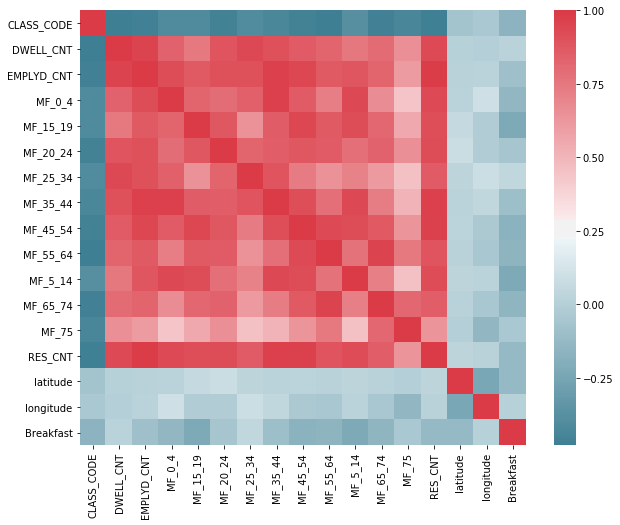

In [105]:
breakfast_corr = breakfast_census.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(breakfast_corr, mask=np.zeros_like(brekfast_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)

In [107]:
brekfast_corr['Breakfast'].sort_values()

MF_5_14      -0.219541
MF_15_19     -0.219344
MF_45_54     -0.167594
CLASS_CODE   -0.162177
MF_55_64     -0.157547
MF_65_74     -0.151949
MF_0_4       -0.139235
latitude     -0.125138
RES_CNT      -0.121087
MF_35_44     -0.092574
EMPLYD_CNT   -0.087024
MF_20_24     -0.061474
MF_75        -0.041933
longitude     0.010927
DWELL_CNT     0.018546
MF_25_34      0.049030
Breakfast     1.000000
Name: Breakfast, dtype: float64

Looks like the biggest correlations with breakfast restaurants are negative correlations with the number of kids and teens in the area. This matches my (purely annecdotal) experience, as I rarely see families with children in breakfast resturants. It seems like areas populated with middle-aged folk are not very keen on eating out for breakfast either.

Let's plot a few of our variables vs breakfast:

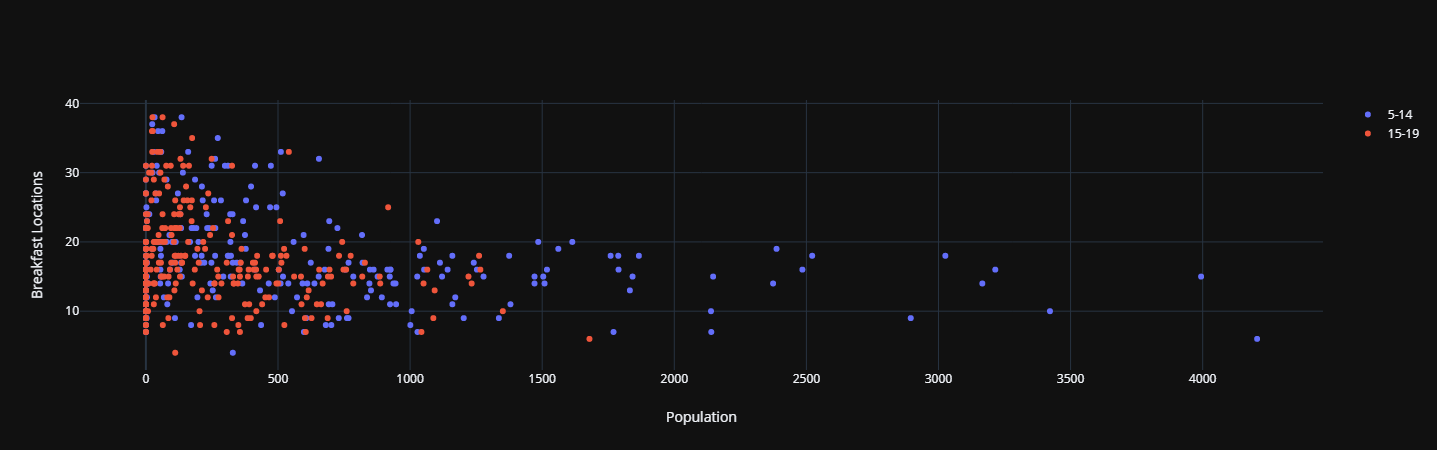

In [125]:
breakfast_kids_trace = go.Scatter(x = breakfast_census['MF_5_14'], y = breakfast_census['Breakfast'], name = '5-14', mode='markers')
breakfast_teen_trace = go.Scatter(x = breakfast_census['MF_15_19'], y = breakfast_census['Breakfast'], name = '15-19', mode='markers')

breakfast_corr_layout = go.Layout(template='plotly_dark', xaxis={'title':'Population'}, yaxis={'title':'Breakfast Locations'})

py.iplot({'data': [breakfast_kids_trace, breakfast_teen_trace], 'layout': breakfast_corr_layout})